Team Members:<br></br>
Mitchell Morrison <br></br>
Kyle Kolodziej<br></br>
Brian Pattison<br></br>
Sam Yassien<br></br>

# Business Case

With lots of fake news swirling around in the last few years, classifying news articles as credible has become an important role of social media companies. We intend on building a model that predicts whether or not the article at hand is fake news or opinion spam. The dataset we are using is from Kaggle (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) and contains ~45000 news articles with proper detail about the title, text of the article, subject, and date of release. For our classifier, we will only be using the title of the article for the prediction. Current socail media giants at facebook and instagram have begun to tag misleading articles with alerts about potential fake news, but as bots become smarter and people become more involved in creating fake news the models need to be more prepared to handle common text phrases that could indicate if an article is fake. Using a Recurrent neural network will help us capture the nuances of sentences to find patterns in clearly fake and not fake news headlines.

Being able to accurately label articles as fake or true is extremely important if social media companies are going to keep this policy as the new norm. Incorrectly identifying an article as fake will discredit credible news stories. On the other hand, if a fake news story is not accurately identified as fake, then people will be more susceptible to believing these fake news stories with the belief that the social media platform should've correctly labeled the article to be false. 
https://news.mit.edu/2020/warning-labels-fake-news-trustworthy-0303

In [451]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import contractions
from sklearn.model_selection import train_test_split
import string
from matplotlib import pyplot as plt
import regex as re
from tensorflow import keras
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
import sklearn.metrics as mt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from scipy import interp
from sklearn.manifold import TSNE

## Reading in the data

In [3]:
true = pd.read_csv("../../news/True.csv")
false = pd.read_csv("../../news/Fake.csv")

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [65]:
true['target'] = 1
false['target'] = 0
NUM_CLASSES = 2

In [7]:
data = pd.concat([true, false], axis=0)
data.shape

(44898, 5)

In [8]:
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [491]:
data.isna().sum()

title      0
text       0
subject    0
date       0
target     0
cleaned    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [28]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

## Tokenizing

To tokenize our text column we will split the sentence into a word vector. We will use word_tokenize from the nltk library to split the sentence into a list of words that we can then properly format contractions within sentences and remove stop words and punctuation. The cleaned data will be returned as a single string.

We are only using our title for the input sequence
. 

Once we have cleaned our input data, we will convert each sentence to a sequence of integers representing the string using Keras preprocessing text tokenizer. We will define a max number of words to use in each sequence so our model can have equal length inputs. 

In [458]:
stop_words = set(stopwords.words('english'))
def clean(txt):
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    words = word_tokenize(txt)
    words = [word.lower() for word in words]
    words = [w for w in words if not w in stop_words]
    words = [contractions.fix(word) for word in words]
    words = [word for word in words if word.isalpha()]
    cleaned_text = ' '.join(words)
    return cleaned_text.strip()

In [459]:
data['cleaned'] = data['title'].apply(lambda txt: clean(txt))

In [460]:
data['cleaned']

0        us budget fight looms republicans flip fiscal ...
1        us military accept transgender recruits monday...
2          senior us republican senator let mr mueller job
3        fbi russia probe helped australian diplomat ti...
4        trump wants postal service charge much amazon ...
                               ...                        
23476    mcpain john mccain furious iran treated us sai...
23477    justice yahoo settles email privacy classactio...
23478    sunnistan us allied safe zone plan take territ...
23479    blow million al jazeera america finally calls ...
23480    us navy sailors held iranian military signs ne...
Name: cleaned, Length: 44898, dtype: object

## Model Evaluation

We will be judging the performance of our model by measuring accuracy and recall (minimizing false positives). We are using recall because it is an important metric that tells us what amount ratio of fake news articles are being properly classified as fake. We want to minimize exposure of fake news cases as much as possible. Accuracy is another important metric to gauge the performance of our model because it tells us the overall performance on both fake and true news articles.

## Test Train Split

We will be splitting our data using an 80/20 shuffle split. With nearly 45,000 data points (44,898 to be exact), our data set is large enough for using one 80/20 split. Additionally, our data set is already close to being balanced between fake news and actual true news. With the data are being balanced, using the 80/20 test_train_split is appropiate as we don't need to worry about using a Stratified Split in order to balance the data. Following this 80/20 split, we will be training our models with nearly 36,000 values (35,918) and testing our models on nearly 9,000 values (8,980).

In [461]:
xtrain, xtest, ytrain, ytest = train_test_split(data['cleaned'], data['target'], shuffle=True, test_size=0.2)

In [462]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((35918,), (8980,), (35918,), (8980,))

In [463]:
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')
max_len = xtest.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 204
Max number of words in a text in training data: 188


## Preprocessing Text to Integer Sequence

Keras text preprocessing libraries text and sequence allow us to easily convert our cleaned sentences into text sequences with padding for our model. 

In [464]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 300

tokenizer = text.Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(xtrain)

xtrain_tok = tokenizer.texts_to_sequences(xtrain)
xtest_tok = tokenizer.texts_to_sequences(xtest)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

xtrain_pad = sequence.pad_sequences(xtrain_tok, maxlen=MAX_ART_LEN)
xtest_pad = sequence.pad_sequences(xtest_tok, maxlen=MAX_ART_LEN)

Found 20733 unique tokens. Distilled to 20733 top words.


In [465]:
print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_tok[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: us budget fight looms republicans flip fiscal script
sequence of indices(before padding): [1954, 2013, 179, 955, 1160, 2342, 2489, 11, 3403, 467]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   

In [466]:
## convert y columns to ohe
ytrain_ohe = keras.utils.to_categorical(ytrain)
ytest_ohe = keras.utils.to_categorical(ytest)

## Glove Embedding

We will be using the glove embedding on our model rather than using embeddings from scratch. This should simplify training because we will not be creating our own weights and do not have to train the pretrained glove embeddings.

In [82]:
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../../glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [467]:
# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Embedding Shape: (20734, 100) 
 Total words found: 18458 
 Percentage: 89.02286100125399


In [468]:
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

## LSTM and GRU

We are investigating the LSTM and GRU recurrent neural network models. We will build each model using the glove embedding layer and create 2 of each kind of model with varying layers and hyperparameters. First we will investigate LSTM, then GRU.

In [137]:
# LSTM number 1

rnn1 = Sequential()
rnn1.add(embedding_layer)
rnn1.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn1.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn1.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy', keras.metrics.Recall()])
print(rnn1.summary())


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1871700   
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 202       
Total params: 1,952,302
Trainable params: 80,602
Non-trainable params: 1,871,700
_________________________________________________________________
None


In [138]:
LSTM1 = []
tmp = rnn1.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM1.append( tmp )

Epoch 1/5
562/562 [==============================] - 327s 582ms/step - loss: 0.1179 - accuracy: 0.9546 - recall_18: 0.9546 - val_loss: 0.0731 - val_accuracy: 0.9748 - val_recall_18: 0.9742
Epoch 2/5
562/562 [==============================] - 327s 581ms/step - loss: 0.0748 - accuracy: 0.9727 - recall_18: 0.9727 - val_loss: 0.0634 - val_accuracy: 0.9765 - val_recall_18: 0.9764
Epoch 3/5
562/562 [==============================] - 326s 580ms/step - loss: 0.0581 - accuracy: 0.9785 - recall_18: 0.9787 - val_loss: 0.0775 - val_accuracy: 0.9716 - val_recall_18: 0.9713
Epoch 4/5
562/562 [==============================] - 326s 580ms/step - loss: 0.0476 - accuracy: 0.9836 - recall_18: 0.9834 - val_loss: 0.0465 - val_accuracy: 0.9834 - val_recall_18: 0.9836
Epoch 5/5
562/562 [==============================] - 328s 584ms/step - loss: 0.0404 - accuracy: 0.9861 - recall_18: 0.9861 - val_loss: 0.0445 - val_accuracy: 0.9845 - val_recall_18: 0.9844


In [139]:
tmp = rnn1.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM1.append(tmp)

Epoch 1/5
562/562 [==============================] - 274s 488ms/step - loss: 0.0351 - accuracy: 0.9880 - recall_18: 0.9879 - val_loss: 0.0445 - val_accuracy: 0.9850 - val_recall_18: 0.9853
Epoch 2/5
562/562 [==============================] - 196s 350ms/step - loss: 0.0300 - accuracy: 0.9895 - recall_18: 0.9894 - val_loss: 0.0678 - val_accuracy: 0.9774 - val_recall_18: 0.9780
Epoch 3/5
562/562 [==============================] - 196s 350ms/step - loss: 0.0262 - accuracy: 0.9911 - recall_18: 0.9912 - val_loss: 0.0404 - val_accuracy: 0.9880 - val_recall_18: 0.9880
Epoch 4/5
562/562 [==============================] - 202s 359ms/step - loss: 0.0223 - accuracy: 0.9919 - recall_18: 0.9919 - val_loss: 0.0365 - val_accuracy: 0.9886 - val_recall_18: 0.9884
Epoch 5/5
562/562 [==============================] - 208s 370ms/step - loss: 0.0183 - accuracy: 0.9935 - recall_18: 0.9935 - val_loss: 0.0484 - val_accuracy: 0.9869 - val_recall_18: 0.9870


In [140]:
tmp = rnn1.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM1.append(tmp)

Epoch 1/5
562/562 [==============================] - 209s 373ms/step - loss: 0.0170 - accuracy: 0.9941 - recall_18: 0.9941 - val_loss: 0.0505 - val_accuracy: 0.9854 - val_recall_18: 0.9856
Epoch 2/5
562/562 [==============================] - 201s 357ms/step - loss: 0.0145 - accuracy: 0.9948 - recall_18: 0.9948 - val_loss: 0.0402 - val_accuracy: 0.9898 - val_recall_18: 0.9895
Epoch 3/5
562/562 [==============================] - 197s 351ms/step - loss: 0.0129 - accuracy: 0.9952 - recall_18: 0.9952 - val_loss: 0.0381 - val_accuracy: 0.9900 - val_recall_18: 0.9898
Epoch 4/5
562/562 [==============================] - 197s 350ms/step - loss: 0.0113 - accuracy: 0.9960 - recall_18: 0.9961 - val_loss: 0.0560 - val_accuracy: 0.9878 - val_recall_18: 0.9879
Epoch 5/5
562/562 [==============================] - 197s 350ms/step - loss: 0.0098 - accuracy: 0.9965 - recall_18: 0.9965 - val_loss: 0.0458 - val_accuracy: 0.9895 - val_recall_18: 0.9896


In [141]:
tmp = rnn1.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM1.append(tmp)

Epoch 1/5
562/562 [==============================] - 197s 350ms/step - loss: 0.0087 - accuracy: 0.9969 - recall_18: 0.9968 - val_loss: 0.0500 - val_accuracy: 0.9884 - val_recall_18: 0.9882
Epoch 2/5
562/562 [==============================] - 197s 351ms/step - loss: 0.0081 - accuracy: 0.9972 - recall_18: 0.9970 - val_loss: 0.0454 - val_accuracy: 0.9895 - val_recall_18: 0.9896
Epoch 3/5
562/562 [==============================] - 198s 353ms/step - loss: 0.0069 - accuracy: 0.9977 - recall_18: 0.9978 - val_loss: 0.0515 - val_accuracy: 0.9908 - val_recall_18: 0.9908
Epoch 4/5
562/562 [==============================] - 196s 349ms/step - loss: 0.0056 - accuracy: 0.9983 - recall_18: 0.9983 - val_loss: 0.0500 - val_accuracy: 0.9904 - val_recall_18: 0.9904
Epoch 5/5
562/562 [==============================] - 196s 349ms/step - loss: 0.0066 - accuracy: 0.9979 - recall_18: 0.9979 - val_loss: 0.0507 - val_accuracy: 0.9900 - val_recall_18: 0.9898


In [235]:
rnn1.save('LSTM1')

INFO:tensorflow:Assets written to: LSTM1/assets


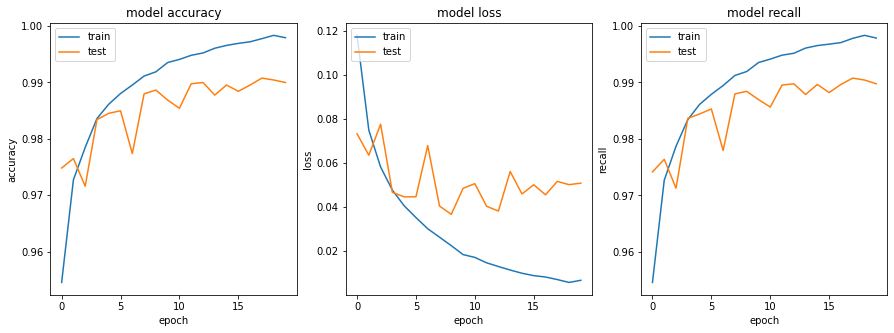

In [222]:
plot_model(LSTM1, '18')

The plots indicate that the model finished training. We can see the loss converge and train data begin to overfit after 15 epochs.

In [142]:
## GRU number 1

rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn2.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy', keras.metrics.Recall()])
print(rnn2.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1871700   
_________________________________________________________________
gru_8 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 202       
Total params: 1,932,502
Trainable params: 60,802
Non-trainable params: 1,871,700
_________________________________________________________________
None


In [143]:
GRU1 = []
tmp = rnn2.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU1.append( tmp )

Epoch 1/5
562/562 [==============================] - 180s 320ms/step - loss: 0.1227 - accuracy: 0.9531 - recall_19: 0.9533 - val_loss: 0.0812 - val_accuracy: 0.9702 - val_recall_19: 0.9703
Epoch 2/5
562/562 [==============================] - 172s 307ms/step - loss: 0.0722 - accuracy: 0.9739 - recall_19: 0.9741 - val_loss: 0.0661 - val_accuracy: 0.9754 - val_recall_19: 0.9753
Epoch 3/5
562/562 [==============================] - 174s 309ms/step - loss: 0.0567 - accuracy: 0.9797 - recall_19: 0.9795 - val_loss: 0.0490 - val_accuracy: 0.9844 - val_recall_19: 0.9840
Epoch 4/5
562/562 [==============================] - 173s 309ms/step - loss: 0.0470 - accuracy: 0.9837 - recall_19: 0.9838 - val_loss: 0.0458 - val_accuracy: 0.9853 - val_recall_19: 0.9851
Epoch 5/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0397 - accuracy: 0.9860 - recall_19: 0.9860 - val_loss: 0.0420 - val_accuracy: 0.9866 - val_recall_19: 0.9869


In [144]:
tmp = rnn2.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU1.append(tmp)

Epoch 1/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0340 - accuracy: 0.9881 - recall_19: 0.9880 - val_loss: 0.0382 - val_accuracy: 0.9884 - val_recall_19: 0.9884
Epoch 2/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0292 - accuracy: 0.9901 - recall_19: 0.9902 - val_loss: 0.0398 - val_accuracy: 0.9889 - val_recall_19: 0.9891
Epoch 3/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0242 - accuracy: 0.9915 - recall_19: 0.9915 - val_loss: 0.0372 - val_accuracy: 0.9902 - val_recall_19: 0.9902
Epoch 4/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0232 - accuracy: 0.9922 - recall_19: 0.9921 - val_loss: 0.0372 - val_accuracy: 0.9900 - val_recall_19: 0.9900
Epoch 5/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0186 - accuracy: 0.9938 - recall_19: 0.9937 - val_loss: 0.0420 - val_accuracy: 0.9893 - val_recall_19: 0.9895


In [145]:
tmp = rnn2.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU1.append(tmp)

Epoch 1/5
562/562 [==============================] - 173s 308ms/step - loss: 0.0157 - accuracy: 0.9945 - recall_19: 0.9945 - val_loss: 0.0396 - val_accuracy: 0.9896 - val_recall_19: 0.9896
Epoch 2/5
562/562 [==============================] - 172s 307ms/step - loss: 0.0147 - accuracy: 0.9949 - recall_19: 0.9952 - val_loss: 0.0417 - val_accuracy: 0.9899 - val_recall_19: 0.9899
Epoch 3/5
562/562 [==============================] - 172s 307ms/step - loss: 0.0126 - accuracy: 0.9952 - recall_19: 0.9951 - val_loss: 0.0390 - val_accuracy: 0.9922 - val_recall_19: 0.9924
Epoch 4/5
562/562 [==============================] - 171s 305ms/step - loss: 0.0115 - accuracy: 0.9961 - recall_19: 0.9960 - val_loss: 0.0371 - val_accuracy: 0.9916 - val_recall_19: 0.9914
Epoch 5/5
562/562 [==============================] - 172s 305ms/step - loss: 0.0102 - accuracy: 0.9964 - recall_19: 0.9965 - val_loss: 0.0403 - val_accuracy: 0.9916 - val_recall_19: 0.9914


In [146]:
tmp = rnn2.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU1.append(tmp)

Epoch 1/5
562/562 [==============================] - 174s 309ms/step - loss: 0.0101 - accuracy: 0.9964 - recall_19: 0.9964 - val_loss: 0.0433 - val_accuracy: 0.9902 - val_recall_19: 0.9903
Epoch 2/5
562/562 [==============================] - 173s 307ms/step - loss: 0.0089 - accuracy: 0.9970 - recall_19: 0.9970 - val_loss: 0.0415 - val_accuracy: 0.9923 - val_recall_19: 0.9922
Epoch 3/5
562/562 [==============================] - 172s 306ms/step - loss: 0.0081 - accuracy: 0.9974 - recall_19: 0.9974 - val_loss: 0.0392 - val_accuracy: 0.9911 - val_recall_19: 0.9910
Epoch 4/5
562/562 [==============================] - 172s 306ms/step - loss: 0.0072 - accuracy: 0.9974 - recall_19: 0.9974 - val_loss: 0.0430 - val_accuracy: 0.9916 - val_recall_19: 0.9918
Epoch 5/5
562/562 [==============================] - 172s 305ms/step - loss: 0.0059 - accuracy: 0.9977 - recall_19: 0.9977 - val_loss: 0.0438 - val_accuracy: 0.9921 - val_recall_19: 0.9922


In [234]:
rnn2.save('GRU1')

INFO:tensorflow:Assets written to: GRU1/assets


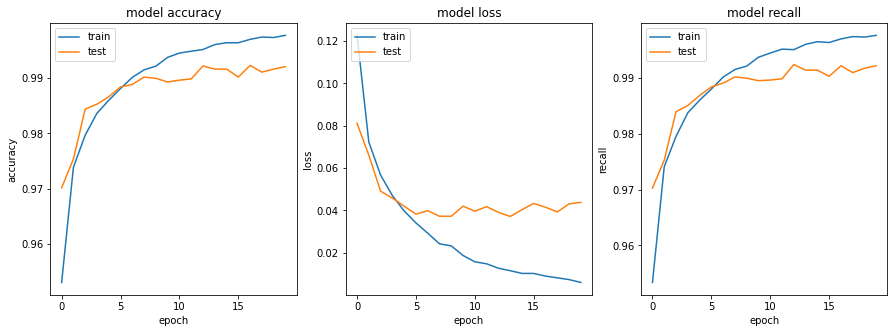

In [223]:
plot_model(GRU1, '19')

In [123]:
## LSTM Number 2

rnn3 = Sequential()
rnn3.add(embedding_layer)
rnn3.add(LSTM(100,dropout=0.3, recurrent_dropout=0.3))
rnn3.add(Dense(50, activation='softmax',kernel_initializer='glorot_uniform'))
rnn3.add(Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform'))
rnn3.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', keras.metrics.Recall()])
print(rnn3.summary())


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1871700   
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_25 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 102       
Total params: 1,957,252
Trainable params: 85,552
Non-trainable params: 1,871,700
_________________________________________________________________
None


In [124]:
LSTM2 = []
tmp = rnn3.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM2.append( tmp )

Epoch 1/5
562/562 [==============================] - 212s 377ms/step - loss: 0.4210 - accuracy: 0.8960 - recall_15: 0.8960 - val_loss: 0.2961 - val_accuracy: 0.9540 - val_recall_15: 0.9540
Epoch 2/5
562/562 [==============================] - 216s 385ms/step - loss: 0.2307 - accuracy: 0.9591 - recall_15: 0.9591 - val_loss: 0.1870 - val_accuracy: 0.9625 - val_recall_15: 0.9625
Epoch 3/5
562/562 [==============================] - 220s 391ms/step - loss: 0.1610 - accuracy: 0.9658 - recall_15: 0.9658 - val_loss: 0.1337 - val_accuracy: 0.9706 - val_recall_15: 0.9706
Epoch 4/5
562/562 [==============================] - 221s 392ms/step - loss: 0.1192 - accuracy: 0.9723 - recall_15: 0.9723 - val_loss: 0.1008 - val_accuracy: 0.9763 - val_recall_15: 0.9763
Epoch 5/5
562/562 [==============================] - 231s 412ms/step - loss: 0.0940 - accuracy: 0.9771 - recall_15: 0.9771 - val_loss: 0.0811 - val_accuracy: 0.9791 - val_recall_15: 0.9791


In [125]:
tmp = rnn3.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM2.append( tmp )

Epoch 1/5
562/562 [==============================] - 226s 403ms/step - loss: 0.0769 - accuracy: 0.9801 - recall_15: 0.9801 - val_loss: 0.0691 - val_accuracy: 0.9820 - val_recall_15: 0.9820
Epoch 2/5
562/562 [==============================] - 217s 386ms/step - loss: 0.0639 - accuracy: 0.9830 - recall_15: 0.9830 - val_loss: 0.0653 - val_accuracy: 0.9814 - val_recall_15: 0.9814
Epoch 3/5
562/562 [==============================] - 214s 382ms/step - loss: 0.0544 - accuracy: 0.9856 - recall_15: 0.9856 - val_loss: 0.0542 - val_accuracy: 0.9852 - val_recall_15: 0.9852
Epoch 4/5
562/562 [==============================] - 207s 368ms/step - loss: 0.0470 - accuracy: 0.9874 - recall_15: 0.9874 - val_loss: 0.0531 - val_accuracy: 0.9854 - val_recall_15: 0.9854
Epoch 5/5
562/562 [==============================] - 214s 380ms/step - loss: 0.0409 - accuracy: 0.9891 - recall_15: 0.9891 - val_loss: 0.0453 - val_accuracy: 0.9879 - val_recall_15: 0.9879


In [126]:
tmp = rnn3.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM2.append( tmp )

Epoch 1/5
562/562 [==============================] - 212s 377ms/step - loss: 0.0372 - accuracy: 0.9892 - recall_15: 0.9892 - val_loss: 0.0419 - val_accuracy: 0.9884 - val_recall_15: 0.9884
Epoch 2/5
562/562 [==============================] - 216s 384ms/step - loss: 0.0335 - accuracy: 0.9901 - recall_15: 0.9901 - val_loss: 0.0433 - val_accuracy: 0.9875 - val_recall_15: 0.9875
Epoch 3/5
562/562 [==============================] - 214s 380ms/step - loss: 0.0285 - accuracy: 0.9921 - recall_15: 0.9921 - val_loss: 0.0421 - val_accuracy: 0.9888 - val_recall_15: 0.9888
Epoch 4/5
562/562 [==============================] - 224s 398ms/step - loss: 0.0268 - accuracy: 0.9920 - recall_15: 0.9920 - val_loss: 0.0371 - val_accuracy: 0.9902 - val_recall_15: 0.9902
Epoch 5/5
562/562 [==============================] - 211s 375ms/step - loss: 0.0245 - accuracy: 0.9927 - recall_15: 0.9927 - val_loss: 0.0362 - val_accuracy: 0.9893 - val_recall_15: 0.9893


In [136]:
tmp = rnn3.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
LSTM2.append( tmp )

Epoch 1/5
562/562 [==============================] - 196s 349ms/step - loss: 0.0223 - accuracy: 0.9932 - recall_15: 0.9932 - val_loss: 0.0363 - val_accuracy: 0.9905 - val_recall_15: 0.9905
Epoch 2/5
562/562 [==============================] - 197s 350ms/step - loss: 0.0214 - accuracy: 0.9937 - recall_15: 0.9937 - val_loss: 0.0456 - val_accuracy: 0.9871 - val_recall_15: 0.9871
Epoch 3/5
562/562 [==============================] - 197s 351ms/step - loss: 0.0183 - accuracy: 0.9948 - recall_15: 0.9948 - val_loss: 0.0363 - val_accuracy: 0.9913 - val_recall_15: 0.9913
Epoch 4/5
562/562 [==============================] - 270s 481ms/step - loss: 0.0173 - accuracy: 0.9946 - recall_15: 0.9946 - val_loss: 0.0347 - val_accuracy: 0.9913 - val_recall_15: 0.9913
Epoch 5/5
562/562 [==============================] - 321s 572ms/step - loss: 0.0157 - accuracy: 0.9955 - recall_15: 0.9955 - val_loss: 0.0379 - val_accuracy: 0.9905 - val_recall_15: 0.9905


In [233]:
rnn3.save('LSTM2')

INFO:tensorflow:Assets written to: LSTM2/assets


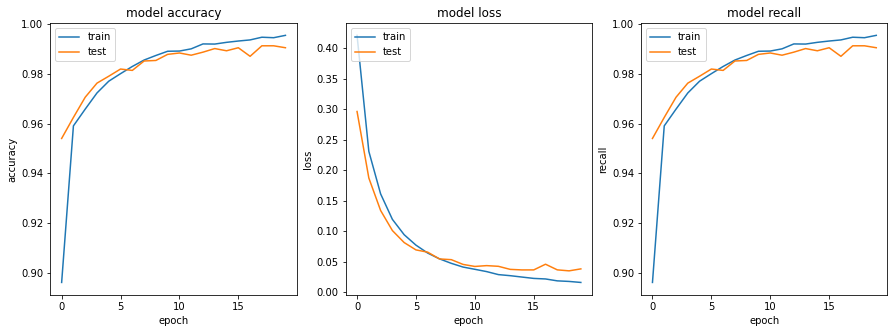

In [224]:
plot_model(LSTM2, '15')

In [129]:
## GRU number 2

rnn4 = Sequential()
rnn4.add(embedding_layer)
rnn4.add(GRU(100,dropout=0.3, recurrent_dropout=0.3))
rnn4.add(Dense(50, activation='softmax',kernel_initializer='glorot_uniform'))
rnn4.add(Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform'))
rnn4.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', keras.metrics.Recall()])
print(rnn4.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1871700   
_________________________________________________________________
gru_7 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 102       
Total params: 1,937,452
Trainable params: 65,752
Non-trainable params: 1,871,700
_________________________________________________________________
None


In [130]:
GRU2 = []
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU2.append( tmp )

Epoch 1/5
562/562 [==============================] - 186s 331ms/step - loss: 0.3424 - accuracy: 0.9403 - recall_17: 0.9403 - val_loss: 0.2154 - val_accuracy: 0.9706 - val_recall_17: 0.9706
Epoch 2/5
562/562 [==============================] - 182s 324ms/step - loss: 0.1757 - accuracy: 0.9705 - recall_17: 0.9705 - val_loss: 0.1406 - val_accuracy: 0.9738 - val_recall_17: 0.9738
Epoch 3/5
562/562 [==============================] - 178s 317ms/step - loss: 0.1207 - accuracy: 0.9754 - recall_17: 0.9754 - val_loss: 0.1040 - val_accuracy: 0.9784 - val_recall_17: 0.9784
Epoch 4/5
562/562 [==============================] - 176s 314ms/step - loss: 0.0904 - accuracy: 0.9798 - recall_17: 0.9798 - val_loss: 0.0819 - val_accuracy: 0.9807 - val_recall_17: 0.9807
Epoch 5/5
562/562 [==============================] - 189s 336ms/step - loss: 0.0740 - accuracy: 0.9825 - recall_17: 0.9825 - val_loss: 0.0609 - val_accuracy: 0.9860 - val_recall_17: 0.9860


In [131]:
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU2.append(tmp)

Epoch 1/5
562/562 [==============================] - 179s 318ms/step - loss: 0.0597 - accuracy: 0.9848 - recall_17: 0.9848 - val_loss: 0.0564 - val_accuracy: 0.9859 - val_recall_17: 0.9859
Epoch 2/5
562/562 [==============================] - 170s 303ms/step - loss: 0.0497 - accuracy: 0.9869 - recall_17: 0.9869 - val_loss: 0.0494 - val_accuracy: 0.9878 - val_recall_17: 0.9878
Epoch 3/5
562/562 [==============================] - 176s 312ms/step - loss: 0.0445 - accuracy: 0.9880 - recall_17: 0.9880 - val_loss: 0.0424 - val_accuracy: 0.9891 - val_recall_17: 0.9891
Epoch 4/5
562/562 [==============================] - 175s 312ms/step - loss: 0.0406 - accuracy: 0.9893 - recall_17: 0.9893 - val_loss: 0.0444 - val_accuracy: 0.9882 - val_recall_17: 0.9882
Epoch 5/5
562/562 [==============================] - 176s 313ms/step - loss: 0.0394 - accuracy: 0.9895 - recall_17: 0.9895 - val_loss: 0.0414 - val_accuracy: 0.9892 - val_recall_17: 0.9892


In [132]:
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU2.append(tmp)

Epoch 1/5
562/562 [==============================] - 172s 307ms/step - loss: 0.0327 - accuracy: 0.9910 - recall_17: 0.9910 - val_loss: 0.0379 - val_accuracy: 0.9908 - val_recall_17: 0.9908
Epoch 2/5
562/562 [==============================] - 170s 302ms/step - loss: 0.0283 - accuracy: 0.9916 - recall_17: 0.9916 - val_loss: 0.0355 - val_accuracy: 0.9918 - val_recall_17: 0.9918
Epoch 3/5
562/562 [==============================] - 211s 375ms/step - loss: 0.0253 - accuracy: 0.9923 - recall_17: 0.9923 - val_loss: 0.0356 - val_accuracy: 0.9912 - val_recall_17: 0.9912
Epoch 4/5
562/562 [==============================] - 275s 490ms/step - loss: 0.0256 - accuracy: 0.9918 - recall_17: 0.9918 - val_loss: 0.0345 - val_accuracy: 0.9920 - val_recall_17: 0.9920
Epoch 5/5
562/562 [==============================] - 274s 488ms/step - loss: 0.0224 - accuracy: 0.9935 - recall_17: 0.9935 - val_loss: 0.0386 - val_accuracy: 0.9905 - val_recall_17: 0.9905


In [135]:
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU2.append(tmp)

Epoch 1/5
562/562 [==============================] - 184s 328ms/step - loss: 0.0205 - accuracy: 0.9939 - recall_17: 0.9939 - val_loss: 0.0371 - val_accuracy: 0.9914 - val_recall_17: 0.9914
Epoch 2/5
562/562 [==============================] - 178s 317ms/step - loss: 0.0179 - accuracy: 0.9944 - recall_17: 0.9944 - val_loss: 0.0386 - val_accuracy: 0.9909 - val_recall_17: 0.9909
Epoch 3/5
562/562 [==============================] - 168s 299ms/step - loss: 0.0172 - accuracy: 0.9945 - recall_17: 0.9945 - val_loss: 0.0333 - val_accuracy: 0.9923 - val_recall_17: 0.9923
Epoch 4/5
562/562 [==============================] - 168s 299ms/step - loss: 0.0349 - accuracy: 0.9918 - recall_17: 0.9918 - val_loss: 0.0354 - val_accuracy: 0.9918 - val_recall_17: 0.9918
Epoch 5/5
562/562 [==============================] - 168s 300ms/step - loss: 0.0147 - accuracy: 0.9953 - recall_17: 0.9953 - val_loss: 0.0349 - val_accuracy: 0.9920 - val_recall_17: 0.9920


In [232]:
rnn4.save('GRU2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: GRU2/assets


In [488]:
rnn5 = keras.models.load_model('GRU2')
# rnn5.summary()

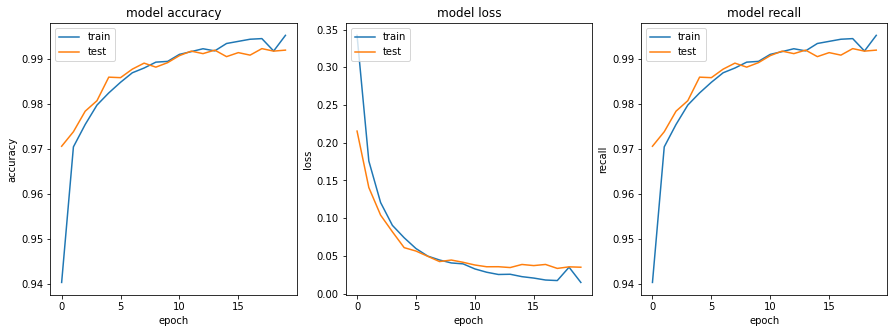

In [226]:
plot_model(GRU2, '17')

In [221]:
def plot_model(history, recallNum):
    # combine all the history from training together
    
    var = 'recall_' + str(recallNum)
    var2 = 'val_recall_' +str(recallNum)

    combined = dict()
    for key in ['accuracy','val_accuracy','loss','val_loss', var , var2]:
        combined[key] = np.hstack([x.history[key] for x in history])

    plt.figure(figsize=(15,5))

    # summarize history for accuracy
    plt.subplot(131)
    plt.plot(combined['accuracy'])
    plt.plot(combined['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(132)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for recall
    plt.subplot(133)
    plt.plot(combined[var])
    plt.plot(combined[var2])
    plt.title('model recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

## 2nd Recurrent Chain

For our next model we will use 2 GRU recurrent chains following the embedding layer. The output of the first GRU will be the input to the next.

In [227]:
## Model with 2 GRU recurrent chains

rnn4 = Sequential()
rnn4.add(embedding_layer)
rnn4.add(GRU(100,dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
rnn4.add(GRU(50,dropout=0.3, recurrent_dropout=0.3))
rnn4.add(Dense(25, activation='softmax',kernel_initializer='glorot_uniform'))
rnn4.add(Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform'))
rnn4.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', keras.metrics.Recall()])
print(rnn4.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1871700   
_________________________________________________________________
gru_9 (GRU)                  (None, 300, 100)          60600     
_________________________________________________________________
gru_10 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dense_33 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 52        
Total params: 1,956,427
Trainable params: 84,727
Non-trainable params: 1,871,700
_________________________________________________________________
None


In [228]:
GRU_2chains = []
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU_2chains.append( tmp )

Epoch 1/5
562/562 [==============================] - 601s 1s/step - loss: 0.3287 - accuracy: 0.9391 - recall_20: 0.9391 - val_loss: 0.2279 - val_accuracy: 0.9601 - val_recall_20: 0.9601
Epoch 2/5
562/562 [==============================] - 581s 1s/step - loss: 0.1804 - accuracy: 0.9668 - recall_20: 0.9668 - val_loss: 0.1390 - val_accuracy: 0.9753 - val_recall_20: 0.9753
Epoch 3/5
562/562 [==============================] - 469s 835ms/step - loss: 0.1209 - accuracy: 0.9748 - recall_20: 0.9748 - val_loss: 0.0950 - val_accuracy: 0.9814 - val_recall_20: 0.9814
Epoch 4/5
562/562 [==============================] - 324s 577ms/step - loss: 0.0932 - accuracy: 0.9787 - recall_20: 0.9787 - val_loss: 0.0859 - val_accuracy: 0.9797 - val_recall_20: 0.9797
Epoch 5/5
562/562 [==============================] - 323s 574ms/step - loss: 0.0746 - accuracy: 0.9815 - recall_20: 0.9815 - val_loss: 0.0634 - val_accuracy: 0.9842 - val_recall_20: 0.9842


In [229]:
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU_2chains.append( tmp )

Epoch 1/5
562/562 [==============================] - 321s 571ms/step - loss: 0.0630 - accuracy: 0.9838 - recall_20: 0.9838 - val_loss: 0.0554 - val_accuracy: 0.9864 - val_recall_20: 0.9864
Epoch 2/5
562/562 [==============================] - 321s 571ms/step - loss: 0.0550 - accuracy: 0.9853 - recall_20: 0.9853 - val_loss: 0.0500 - val_accuracy: 0.9866 - val_recall_20: 0.9866
Epoch 3/5
562/562 [==============================] - 375s 666ms/step - loss: 0.0474 - accuracy: 0.9864 - recall_20: 0.9864 - val_loss: 0.0445 - val_accuracy: 0.9899 - val_recall_20: 0.9899
Epoch 4/5
562/562 [==============================] - 779s 1s/step - loss: 0.0434 - accuracy: 0.9874 - recall_20: 0.9874 - val_loss: 0.0455 - val_accuracy: 0.9866 - val_recall_20: 0.9866
Epoch 5/5
562/562 [==============================] - 771s 1s/step - loss: 0.0391 - accuracy: 0.9884 - recall_20: 0.9884 - val_loss: 0.0428 - val_accuracy: 0.9881 - val_recall_20: 0.9881


In [230]:
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU_2chains.append( tmp )

Epoch 1/5
562/562 [==============================] - 757s 1s/step - loss: 0.0362 - accuracy: 0.9891 - recall_20: 0.9891 - val_loss: 0.0402 - val_accuracy: 0.9891 - val_recall_20: 0.9891
Epoch 2/5
562/562 [==============================] - 309s 549ms/step - loss: 0.0311 - accuracy: 0.9906 - recall_20: 0.9906 - val_loss: 0.0395 - val_accuracy: 0.9885 - val_recall_20: 0.9885
Epoch 3/5
562/562 [==============================] - 337s 600ms/step - loss: 0.0289 - accuracy: 0.9913 - recall_20: 0.9913 - val_loss: 0.0393 - val_accuracy: 0.9890 - val_recall_20: 0.9890
Epoch 4/5
562/562 [==============================] - 343s 610ms/step - loss: 0.0275 - accuracy: 0.9916 - recall_20: 0.9916 - val_loss: 0.0401 - val_accuracy: 0.9898 - val_recall_20: 0.9898
Epoch 5/5
562/562 [==============================] - 310s 552ms/step - loss: 0.0265 - accuracy: 0.9920 - recall_20: 0.9920 - val_loss: 0.0372 - val_accuracy: 0.9901 - val_recall_20: 0.9901


In [231]:
tmp = rnn4.fit(xtrain_pad, ytrain_ohe, validation_data=(xtest_pad, ytest_ohe), epochs=5, batch_size=64)
GRU_2chains.append( tmp )

Epoch 1/5
562/562 [==============================] - 312s 555ms/step - loss: 0.0242 - accuracy: 0.9919 - recall_20: 0.9919 - val_loss: 0.0363 - val_accuracy: 0.9901 - val_recall_20: 0.9901
Epoch 2/5
562/562 [==============================] - 311s 553ms/step - loss: 0.0240 - accuracy: 0.9928 - recall_20: 0.9928 - val_loss: 0.0340 - val_accuracy: 0.9912 - val_recall_20: 0.9912
Epoch 3/5
562/562 [==============================] - 310s 551ms/step - loss: 0.0228 - accuracy: 0.9925 - recall_20: 0.9925 - val_loss: 0.0360 - val_accuracy: 0.9908 - val_recall_20: 0.9908
Epoch 4/5
562/562 [==============================] - 310s 552ms/step - loss: 0.0196 - accuracy: 0.9942 - recall_20: 0.9942 - val_loss: 0.0386 - val_accuracy: 0.9911 - val_recall_20: 0.9911
Epoch 5/5
562/562 [==============================] - 309s 550ms/step - loss: 0.0192 - accuracy: 0.9933 - recall_20: 0.9933 - val_loss: 0.0357 - val_accuracy: 0.9913 - val_recall_20: 0.9913


In [238]:
rnn4.save('GRU2_chains')

INFO:tensorflow:Assets written to: GRU2_chains/assets


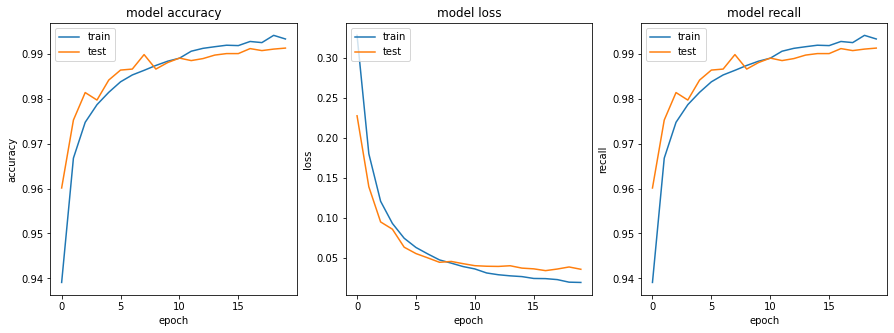

In [236]:
plot_model(GRU_2chains, '20')

## Visualizing Performance and Comparing Models

In this section we will plot the model accuracy, loss, and recall of each recurrent neural network we have trained. 

First we will look at the confusion matrices / heat maps of the models.

In [391]:
def plot_roc(probas, xtest_pad, ytest):
    '''return fpr, tpr, mean_auc to summarize_net'''
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(ytest)
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(ytest,
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += np.interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    mean_auc = auc(mean_fpr, mean_tpr)
    
    return mean_fpr, perclass_mean_tpr, mean_auc

In [416]:
def summarize_net(net, X_test, y_test, title_text=''):
    probas = net.predict(X_test)
    yhat = np.argmax(probas, axis=1)
    yhat = np.array(yhat, dtype='int')
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    returnVal = cm
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    
    plt.figure(figsize = (12,6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , 
                linewidth = 1 , annot = True, fmt='.3f')
    plt.title(title_text+'{:.4f}'.format(acc))    
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, mean_auc = plot_roc(probas, X_test, y_test)
    plt.plot(fpr, tpr,'k-',lw=2,label=' (area = %0.5f)'
                       % (mean_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    return returnVal

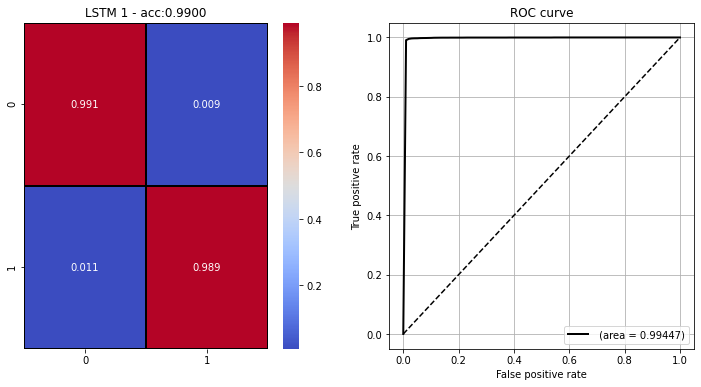

[[4621   44]
 [  46 4269]]


In [417]:
rnn1_cm = summarize_net(rnn1, xtest_pad, ytest, title_text='LSTM 1 - acc:')
print(rnn1_cm)

We can see from the confusion matrix and roc curves above that rnn1 using an LSTM and a single dense layer for output brings us to an accuracy of 99.0% after 20 epochs of training.

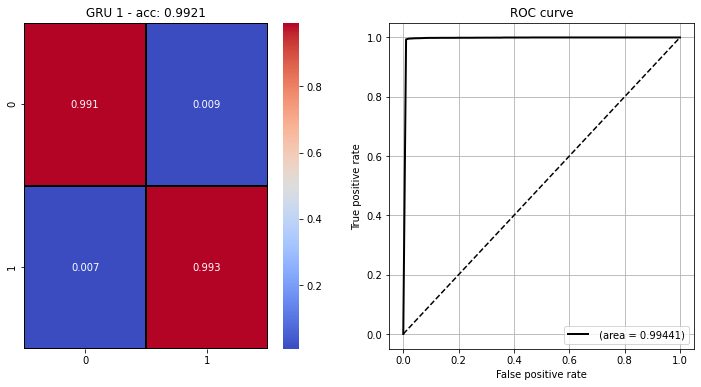

In [418]:
rnn2_cm = summarize_net(rnn2, xtest_pad, ytest, title_text='GRU 1 - acc: ')

We can see from the confusion matrix and roc curves above that rnn2 using an GRU and a single dense layer for output brings us to an accuracy of 99.2% after 20 epochs of training.

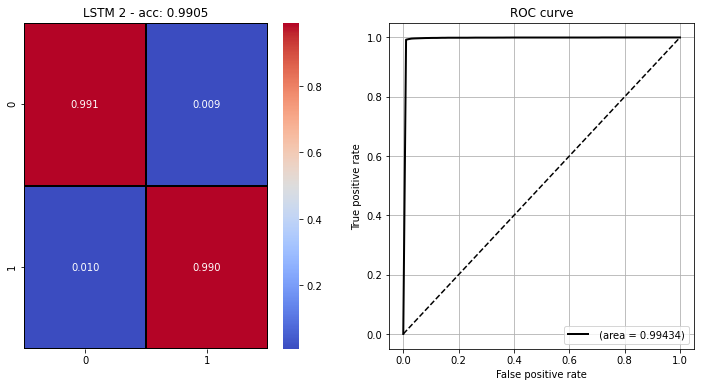

In [419]:
rnn3_cm = summarize_net(rnn3, xtest_pad, ytest, title_text='LSTM 2 - acc: ')

We can see from the confusion matrix and roc curves above that rnn3 using an LSTM, an intermediary dense layer with 50 nodes, and a final dense output layer brings us to an accuracy of 99.05% after 20 epochs of training.

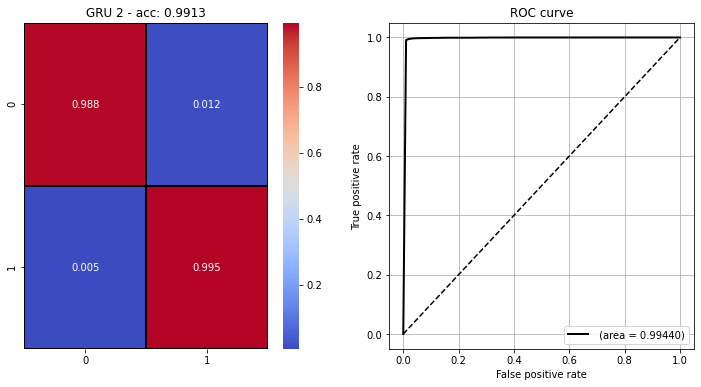

In [439]:
rnn5_cm = summarize_net(rnn5, xtest_pad, ytest, title_text='GRU 2 - acc: ')

We can see from the confusion matrix and roc curves above that rnn5 using a GRU with an intermediary dense layer of 50 nodes and a final dense output layer brings us to an accuracy of 99.13% after 20 epochs of training.

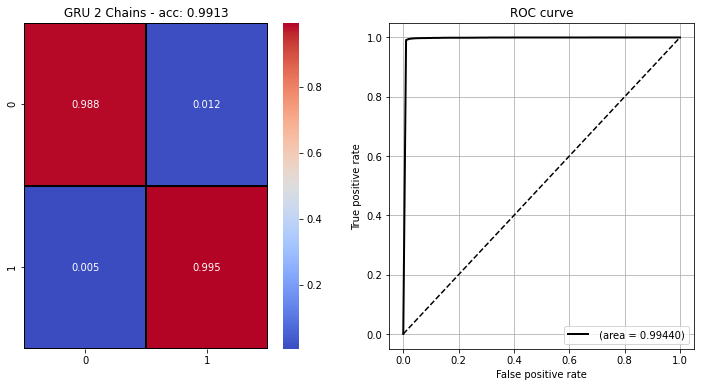

In [420]:
rnn4_cm = summarize_net(rnn4, xtest_pad, ytest, title_text='GRU 2 w/ 2 Recurrent Chains - acc: ')

We can see from the confusion matrix and roc curves above that rnn4 using 2 GRU layers, an intermediary dense layer with 25 nodes, and a final dense layer for output brings us to an accuracy of 99.13% after 20 epochs of training. This model is the highest performing model with the 2 recurrent layers.

## McNemar Testing

### null hypothesis is that the models are the same and we reject this is p < .05

In [433]:
from statsmodels.stats.contingency_tables import mcnemar
def mcnemar_test(mod1_matrix, mod2_matrix) :
    table = [[mod1_matrix[1][1] + mod1_matrix[0][0], mod1_matrix[1][0] + mod1_matrix[0][1]],
    [mod2_matrix[1][0] + mod2_matrix[0][1], mod2_matrix[1][1] + mod2_matrix[0][0]]]
    result = mcnemar(table, exact=True)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print("Same proportions of errors (don't reject H0)")
    else:
        print('Different proportions of errors (reject H0)')

### Comparing different recurrent architectures with like models

In [434]:
## comparing our first LSTM and GRU models with each a single dense layer following the rnn unique architecture layer
mcnemar_test(rnn1_cm, rnn2_cm)

[[8890, 90], [71, 8909]]
statistic=71.000, p-value=0.156
Same proportions of errors (don't reject H0)


In [445]:
## comparing our second LSTM and GRU models with each an intermediary then final dense layer following the rnn unique architecture layer
mcnemar_test(rnn3_cm, rnn5_cm)

[[8895, 85], [78, 8902]]
statistic=78.000, p-value=0.639
Same proportions of errors (don't reject H0)


Both of the mcnemar tests above indicate that the models of the different LSTM or GRU architecture with similar layers perform very similarly and therefore we cannot reject the null hypothesis.

### Comparing different model types of the same recurrent architecture (LSTM or GRU)

In [437]:
## comparing our LSTM models. rnn1 has a single final dense layer where rnn3 has 2 dense layers following the LSTM
mcnemar_test(rnn1_cm, rnn3_cm)

[[8890, 90], [85, 8895]]
statistic=85.000, p-value=0.762
Same proportions of errors (don't reject H0)


In [440]:
## comparing our GRU models. rnn2 has a single final dense layer where rnn5 (not rnn4, ran out of order) has 2 dense layers following the GRU operation
mcnemar_test(rnn2_cm, rnn5_cm)

[[8909, 71], [78, 8902]]
statistic=71.000, p-value=0.623
Same proportions of errors (don't reject H0)


Both of the mcnemar tests above indicate that the models of the same LSTM or GRU architecture with different layers perform very similarly and therefore we cannot reject the null hypothesis.

### Comparing different models with different architectures

In [443]:
#comparing a basic LSTM to a more complex GRU model
mcnemar_test(rnn1_cm, rnn5_cm)

[[8890, 90], [78, 8902]]
statistic=78.000, p-value=0.396
Same proportions of errors (don't reject H0)


In [446]:
#comparing a basic GRU to a more complex LSTM model
mcnemar_test(rnn2_cm, rnn3_cm)

[[8909, 71], [85, 8895]]
statistic=71.000, p-value=0.298
Same proportions of errors (don't reject H0)


Both of the mcnemar tests above indicate that the models of the different LSTM or GRU architecture and different layers perform very similarly and therefore we cannot reject the null hypothesis.

### Comparing all models to the single model with 2 GRU layers

In [447]:
mcnemar_test(rnn1_cm, rnn4_cm)
mcnemar_test(rnn2_cm, rnn4_cm)
mcnemar_test(rnn3_cm, rnn4_cm)
mcnemar_test(rnn5_cm, rnn4_cm)

[[8890, 90], [78, 8902]]
statistic=78.000, p-value=0.396
Same proportions of errors (don't reject H0)
[[8909, 71], [78, 8902]]
statistic=71.000, p-value=0.623
Same proportions of errors (don't reject H0)
[[8895, 85], [78, 8902]]
statistic=78.000, p-value=0.639
Same proportions of errors (don't reject H0)
[[8902, 78], [78, 8902]]
statistic=78.000, p-value=1.000
Same proportions of errors (don't reject H0)


All of the mcnemar tests above indicate that the all of our models do not vary significantly from the model with 2 recurrent GRU layers. We cannot reject the null hypothesis and therefore conclude that all of the models created in this notebook perform very similarly on this dataset. To determine which models are superior, we will look at the accuracy and recall scores.

## Superior Models

The superior models based on the performance metrics of accuracy and recall from the training done above are models RNN2 and RNN5. RNN2 meets an accuracy of 99.21%, a whopping .1% higher than the highest LSTM model. RNN5 meets an accuracy of 99.22 percent as well. The recall on models RNN2 and RNN5 are at ~99.22 and 99.20% recall, respectively. Both of these value are also about .1% higher than the LSTM models. 

Since both of the leading RNN's are using GRU, we can assume that for this particular dataset and circumstances that GRU is the better model of choice. Additionally, it takes less time for our models to train using GRU than LSTM, making it even more superior. 

Although we are really picking teeth by comparing the models over .1% accuracy, we can see both LSTM and GRU models using the pretrained glove embeddings performed very well on this fake news classification dataset. 

# Exceptional Work

The following exceptional work will be visualizing and analyzing the word embeddings of our RNN5. 

(20734, 100)


/Library/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

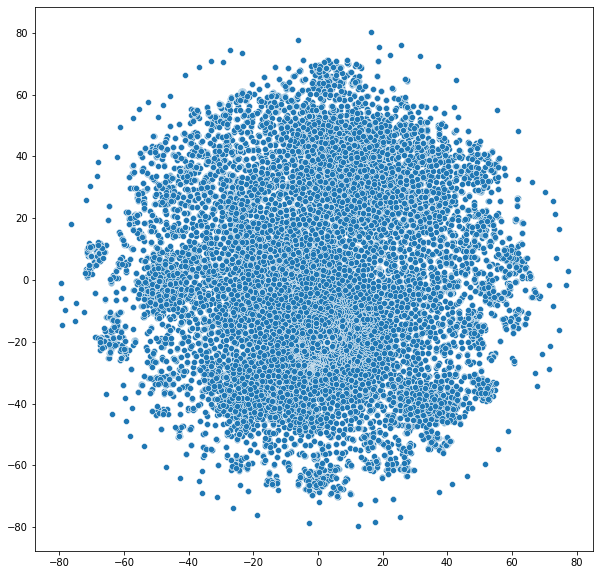

In [474]:
weights = rnn5.get_layer('embedding_1').get_weights()[0]
print(weights.shape)
embd_reduced = TSNE(n_components=2).fit_transform(weights)
embd_reduced.shape
plt.figure(figsize=(10,10))
sns.scatterplot(embd_reduced[:,0], embd_reduced[:,1])

#sourse for plot: https://towardsdatascience.com/the-simple-approach-to-word-embedding-for-natural-language-processing-using-python-ae028c8dbfd2

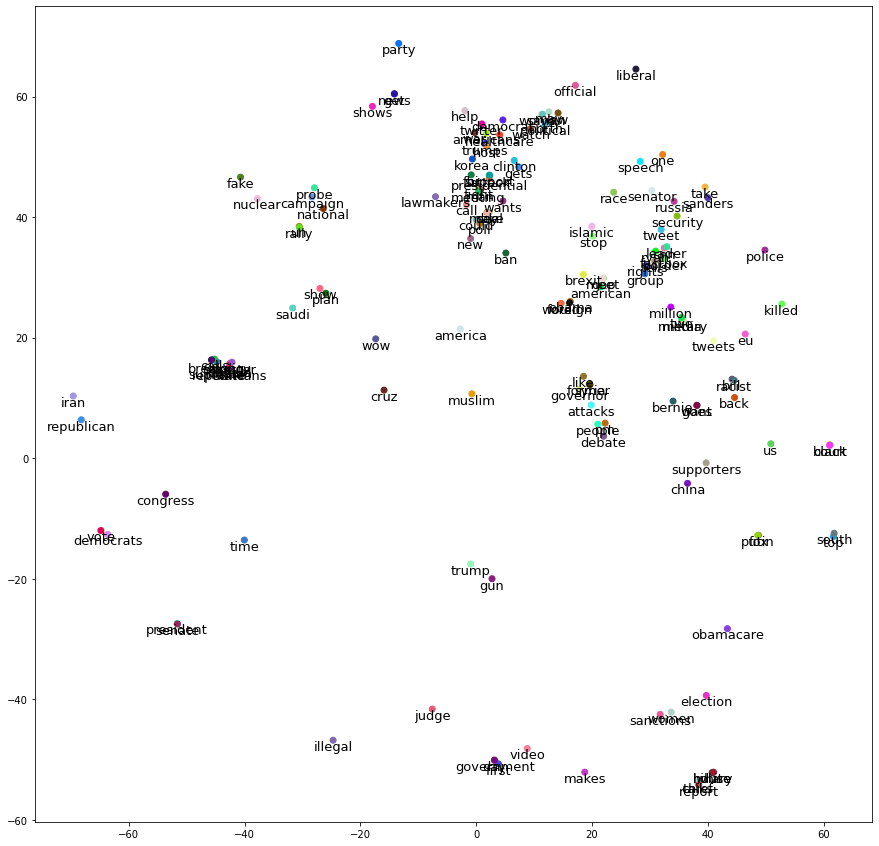

In [487]:
word_list = list(word_index)
idx = np.random.randint(top_words, size=150)
plt.figure(figsize=(15,15))
plt.scatter(embd_reduced[:150,0], embd_reduced[:150,1], c = np.random.rand(150,3))
for key in range(150):
    plt.annotate(word_list[key], xy=(embd_reduced[key, 0], embd_reduced[key, 1]), ha='center', va='top', size=13)
plt.show()

The above PCA dimension reduction indicates words with similar affect on the neural network based on proximity in the graph. Words like "vote" and "democrat" rank similarly with the PCA as well as "trump" and "gun", "russia" and "security", "police" and "killed", and "probe" and "campaign". These similarly ranked / weighted words help the neural net find patterns between words in different "fake" or "real" news headlines. 

The PCA is clustering similar words from our embeddings but not necessarily separating words that appear in fake news from real news. We can see common phrases and or 2 word conjunctions that represent frequent phrases or words likely to appear in the same headline.